In [1]:
import gym
import gym_anytrading

from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions 
from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK, STOCKS_GOOGL
import matplotlib.pyplot as plt
from keras import applications
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, Input, Concatenate, Conv2D
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.agents.ddpg import DDPGAgent
from rl.policy import BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.random import OrnsteinUhlenbeckProcess
from rl.callbacks import FileLogger, ModelIntervalCheckpoint, TrainIntervalLogger

from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')

import json
import numpy as np

Using TensorFlow backend.
d:\tech\mtech\sls\project2\env\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\tech\mtech\sls\project2\env\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\tech\mtech\sls\project2\env\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\tech\mtech\sls\project2\env\lib\site-packages\tensorflow\py

In [2]:
class EnvProcessor(Processor):
    def process_observation(self, observation):
        assert observation.ndim == 2  # (height, width, channel)
        return self.process_obs_1(observation)
    
    def process_obs_1(self, observation):
        prices = []
        diff = []
        for o in observation:
            prices.append(o[0])
            diff.append(o[1])
        prices = preprocessing.normalize([prices], norm='l2', axis=1, copy=True, return_norm=False)[0]
        diff = preprocessing.normalize([diff], norm='l2', axis=1, copy=True, return_norm=False)[0]
        new_obs = np.column_stack((prices, diff))
        return new_obs
    
    def process_obs_2(self, observation):
        prices = []
        diff = []
        for o in observation:
            prices.append(o[0])
            diff.append(o[1] / o[0] * 100)
        prices = preprocessing.normalize([prices], norm='l2', axis=1, copy=True, return_norm=False)[0]
        new_obs = np.column_stack((prices, diff))
        return new_obs
        
    def process_state_batch(self, batch):
#         print(batch)
        return batch

    def process_reward(self, reward):
        return reward

In [3]:
def env_creator():
    return gym.make('forex-v0', frame_bound=(50, 2500), window_size=10)

env = env_creator()
nb_actions = env.action_space.n

def buildModel():
    # Next, we build a very simple model.
    model = Sequential()
    model.add(Conv2D(input_shape=(1,) + env.observation_space.shape, filters=32, kernel_size=(4,2), padding='same'))
    model.add(Conv2D(filters=64, kernel_size=(4,2), padding='same'))
    model.add(Conv2D(filters=128, kernel_size=(4,2), padding='same'))
    model.add(Conv2D(filters=128, kernel_size=(4,2), padding='same'))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(nb_actions, activation='linear'))
    return model
buildModel().summary()
def agent_creator():
    processor = EnvProcessor()
    memory = SequentialMemory(limit=100000, window_length=1)
    # policy = CustomEpsGreedyQPolicy(update_interval = 2500, eps = 1.0)
    policy = BoltzmannQPolicy()
    agent = DQNAgent(model=buildModel(), nb_actions=nb_actions, memory=memory, nb_steps_warmup=20,
                   target_model_update=1e-2, policy=policy, batch_size=64, processor=processor, 
                   train_interval=32, enable_double_dqn=True)
    agent.compile(Adam(lr=1e-3), metrics=['mae'])
    return agent

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 10, 32)         544       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 10, 64)         16448     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 10, 128)        65664     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 10, 128)        131200    
_________________________________________________________________
flatten_1 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1311744   
_________________________________________________________________
dens

['loss', 'mean_absolute_error', 'mean_q']
starting train 1
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
 32/489 [>.............................] - ETA: 38s - reward: 2.5344 - cumulative_reward: 24.5344WARNING:tensorflow:From d:\tech\mtech\sls\project2\env\lib\site-packages\tensorflow\python\ops\math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
485/489 [============================>.] - ETA: 0s - reward: 4.4157 - cumulative_reward: 196.6140
train 1 completed. total_reward: 40.99999999994415 total_profit: 0.8370637788772787
min reward: -199.30000000000004, max reward: 77.19999999999949, mean_reward: 0.01674152715391758


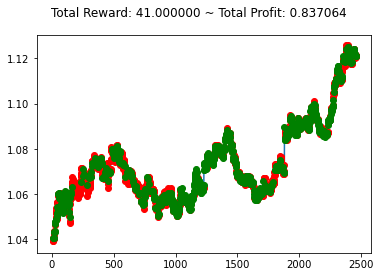

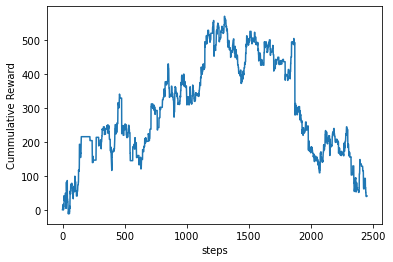


['loss', 'mean_absolute_error', 'mean_q']
starting train 2
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
484/489 [============================>.] - ETA: 0s - reward: -13.5567 - cumulative_reward: -503.2277
train 2 completed. total_reward: -1428.10000000009 total_profit: 0.7801062681423495
min reward: -181.00000000000006, max reward: 76.20000000000182, mean_reward: -0.5831359738669212


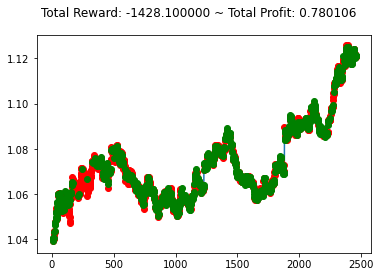

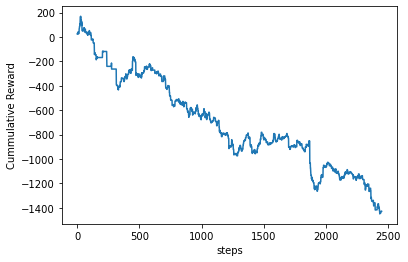


['loss', 'mean_absolute_error', 'mean_q']
starting train 3
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
487/489 [============================>.] - ETA: 0s - reward: -1.2369 - cumulative_reward: 45.1102
train 3 completed. total_reward: -16.900000000068005 total_profit: 0.83711002651549
min reward: -146.60000000000116, max reward: 59.200000000001474, mean_reward: -0.006900775826895878


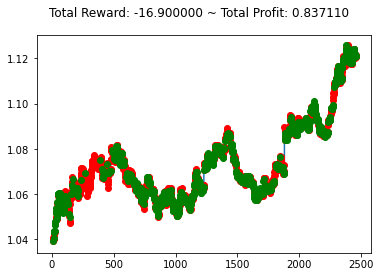

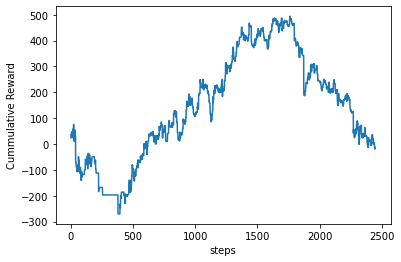


['loss', 'mean_absolute_error', 'mean_q']
starting train 4
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
486/489 [============================>.] - ETA: 0s - reward: -8.8443 - cumulative_reward: -505.4373
train 4 completed. total_reward: -881.3000000000333 total_profit: 0.8413137597226736
min reward: -138.60000000000207, max reward: 88.2000000000005, mean_reward: -0.35986116782361505


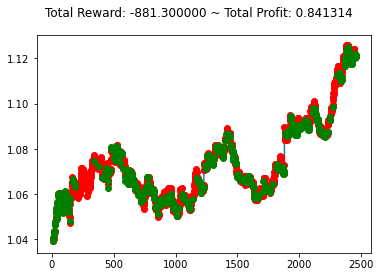

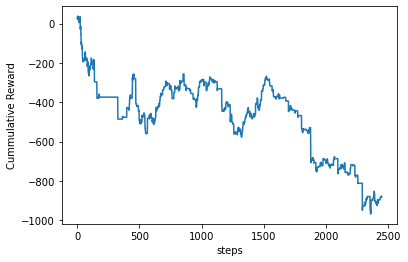


['loss', 'mean_absolute_error', 'mean_q']
starting train 5
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
487/489 [============================>.] - ETA: 0s - reward: 0.1357 - cumulative_reward: -54.7551
train 5 completed. total_reward: 65.79999999996939 total_profit: 0.8387782683615854
min reward: -185.10000000000025, max reward: 70.5, mean_reward: 0.026868109432408895


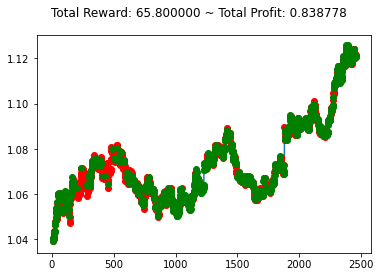

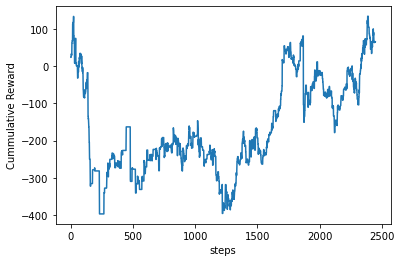


['loss', 'mean_absolute_error', 'mean_q']
starting train 6
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
488/489 [============================>.] - ETA: 0s - reward: 0.2117 - cumulative_reward: -200.3440
train 6 completed. total_reward: 107.89999999999819 total_profit: 0.852380065930508
min reward: -95.09999999999907, max reward: 195.19999999999982, mean_reward: 0.04405879951000334


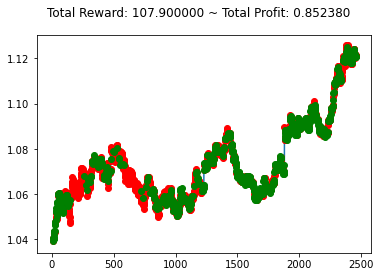

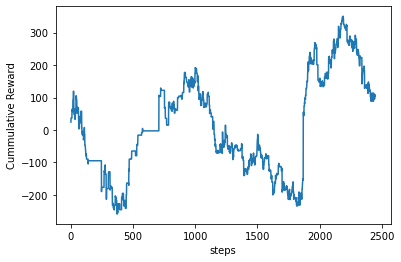


['loss', 'mean_absolute_error', 'mean_q']
starting train 7
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
486/489 [============================>.] - ETA: 0s - reward: 4.6473 - cumulative_reward: -209.0433
train 7 completed. total_reward: -431.6000000000017 total_profit: 0.827092331208957
min reward: -147.20000000000067, max reward: 81.59999999999945, mean_reward: -0.17623519804001703


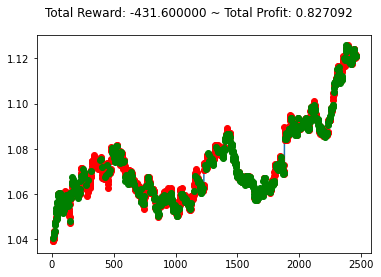

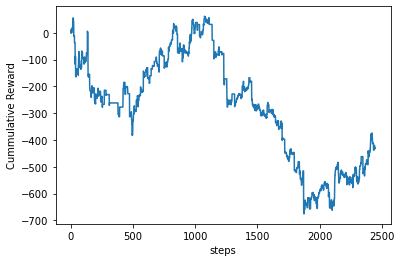


['loss', 'mean_absolute_error', 'mean_q']
starting train 8
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
487/489 [============================>.] - ETA: 0s - reward: -0.9692 - cumulative_reward: -263.8615
train 8 completed. total_reward: -479.70000000002403 total_profit: 0.8541781214750271
min reward: -101.10000000000063, max reward: 168.70000000000164, mean_reward: -0.19587586770111232


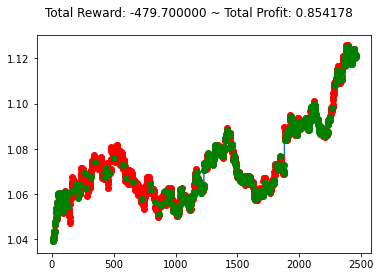

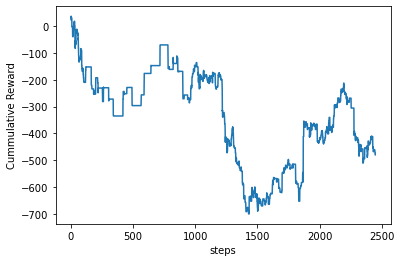


['loss', 'mean_absolute_error', 'mean_q']
starting train 9
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
489/489 [============================>.] - ETA: 0s - reward: 0.1927 - cumulative_reward: 47.3332
train 9 completed. total_reward: 94.40000000011223 total_profit: 0.8340952676132007
min reward: -168.70000000000164, max reward: 66.89999999999863, mean_reward: 0.0385463454471671


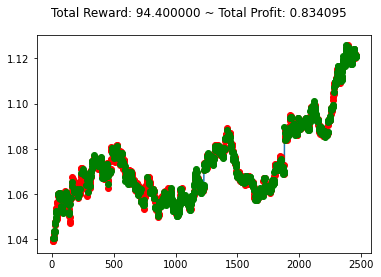

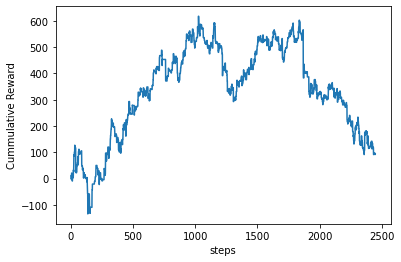


['loss', 'mean_absolute_error', 'mean_q']
starting train 10
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
488/489 [============================>.] - ETA: 0s - reward: -10.6690 - cumulative_reward: 257.3044  ETA: 17s - reward
train 10 completed. total_reward: 613.6000000000101 total_profit: 0.8601639750385504
min reward: -92.70000000000111, max reward: 168.70000000000164, mean_reward: 0.2505512454062924


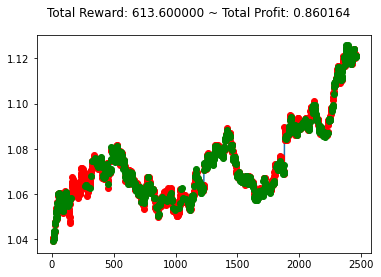

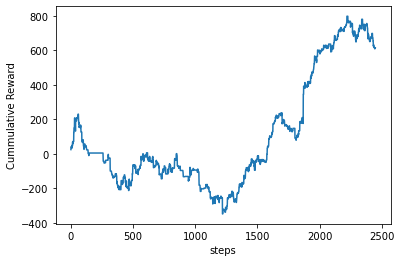

In [4]:
from evaluator import Evaluator

e = Evaluator(agent_creator, env_creator, name="dqn")
e.train(repeat=10)

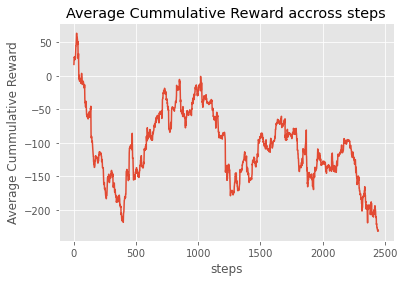

In [5]:
e.process_train_result()

Testing for 1 episodes ...
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
199/199 [============================>.] - ETA: 0s - reward: 3.5736 - cumulative_reward: 134.0400  ETA: 32s - reward: 13.1850 -  - ETA: 10s - reward: 6.4764 - cumulatEpisode 1: reward: 114.600, steps: 999

test completed. total_reward: 114.60000000003348 total_profit: 0.9344417851528377
min reward: -63.10000000000038, max reward: 71.60000000000055, mean_reward: 0.11471471471474823



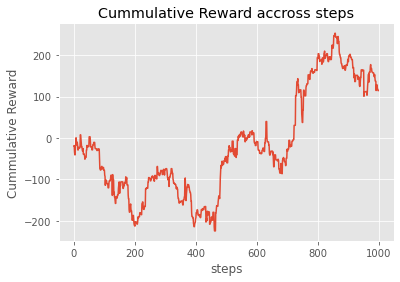

In [6]:
e.test(gym.make('forex-v0', frame_bound=(5000, 6000), window_size=10))